# TP réaliser par le quadrinome : 
- AIT AMARA Mohamed, 181831072170
- BOUROUINA Rania, 181831052716
- CHIBANE Ilies, 181831072041
- HAMMAL Ayoub, 181831048403

# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de confusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape

(5000, 400)

In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y[Y == 10] = 0
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

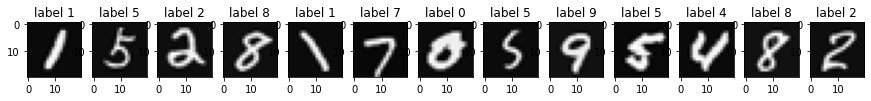

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion

In [91]:
def confusion_matrix(y_true, y_pred):
    #On obtient les classes distinctes et leurs nombres
    y_true_no_duplicate = sorted(set(y_true))
    n = len(y_true_no_duplicate)
    #On intialise la matricde de confusion
    matrix = np.zeros((n,n), dtype=np.int32)
    
    for i in range(len(y_true)):
        matrix[y_true_no_duplicate.index(y_true[i])][y_true_no_duplicate.index(y_pred[i])] += 1
    
    return matrix

- Rappel


In [7]:
def Recall(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tp = 0
    fn = 0
    recall = []
    for i in range(Nbr):
        tp = mat[i][i]
        fn = mat[(i+1):,i].sum() + mat[:i,i].sum()
        recall.append(0 if (tp+fn) == 0 else (tp/(tp+fn)))
    return recall[0] if Nbr == 2 else recall

- Précision

In [8]:
def Precision(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tp = 0
    fp = 0
    precision = []
    for i in range(Nbr):
        tp = mat[i][i]
        fp = mat[i,(i+1):].sum() + mat[i,:i].sum()
        precision.append(0 if (tp+fp) == 0 else (tp/(tp+fp)))
    return precision[0] if Nbr == 2 else precision

- Taux de FP

In [9]:
def FPR(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tp = 0
    fp = 0
    fpr = []
    for i in range(Nbr):
        tp = mat[i][i]
        fp = mat[i,(i+1):].sum() + mat[i,:i].sum()
        fpr.append(0 if (tp+fp) == 0 else (fp/(tp+fp)))
    return fpr[0] if Nbr == 2 else fpr

- Spécificité

In [10]:
def Specificity(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    Nbr = len(sorted(set(y_true)))
    i = 0
    tn = 0
    fp = 0
    specificity = []
    for i in range(Nbr):
        tp = mat[:i,:i].sum() + mat[(i+1):,:i].sum() + mat[:i,(i+1):].sum() + mat[(i+1):,(i+1):].sum()
        fp = mat[i,(i+1):].sum() + mat[i,:i].sum()
        specificity.append(0 if (tp+fp) == 0 else (tp/(tp+fp)))
    return specificity[0] if Nbr == 2 else specificity

- Courbe ROC

In [11]:
def ROC(y_true,y_pred,y_score):
    thresholds = [0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1,2]
    y_true_no_duplicate = sorted(set(y_true))
    tp = 0
    fp = 0
    tn = 0
    All_roc = []
    roc = []
    for y in y_true_no_duplicate:
        indices = [i for i, x in enumerate(y_true) if x == y]
        for threshold in thresholds:
            for i in indices: 
                if(y_score[i][y_pred[i]] >= threshold):
                    if(y_true[i] == y_pred[i]):
                        tp += 1
                    else:
                        fp += 1
                elif(y_score[i][y_pred[i]] < threshold):
                    if(y_true[i] == y_pred[i]):
                        tn += 1
            tpr = 0 if (tp+fp) == 0 else (tp/(tp+fp))
            fpr = 0 if (tn+fp) == 0 else (fp/(tn+fp))
            roc.append([fpr,tpr])
            tp = 0
            fp = 0
            tn = 0
        
        fpr_array = []
        tpr_array = []
        for i in range(len(roc)-1):
            point1 = roc[i]
            point2 = roc[i+1]
            tpr_array.append([point1[0], point2[0]])
            fpr_array.append([point1[1], point2[1]])
        All_roc.append([tpr_array,fpr_array])
    
    colors = ['blue', 'yellow', 'black', 'olive', 'green', 'pink', 'orange', 'brown', 'purple', 'red']
    i = 0
    for ar in All_roc:
        plt.plot(ar[0][0],ar[0][1], color = colors[i])
        i += 1
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All ROC Curves')
    plt.show()

In [59]:
def metrics(Ytt, y_pred):
    print("Matrice de Confusion :")
    print(confusion_matrix(Ytt, y_pred))

    print("\nRappel :")
    recall = Recall(Ytt, y_pred)
    print(recall)
    print("Rappel mean = ", np.array(recall).mean())
    print('-------------------------------------------------------')

    print("Precision :")
    precision = Precision(Ytt, y_pred)
    print(precision)
    print("\nPrecision mean = ", np.array(precision).mean())

    print("Taux de FP :")
    fpr = FPR(Ytt, y_pred)
    print(fpr)
    print("\nTaux de FP mean = ", np.array(fpr).mean())
    print('-------------------------------------------------------')

    print("Specificite :")
    specificty = Specificity(Ytt, y_pred)
    print(specificty)
    print("\nSpecificty mean = ", np.array(specificty).mean(), end="")

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [60]:
tRatio=2/3
ttRatio=1/3
Xt, Xtt, Yt, Ytt = train_test_split(X,Y,test_size=ttRatio, train_size=tRatio)
print(Xt.shape,Xtt.shape,Yt.shape,Ytt.shape)

(3333, 400) (1667, 400) (3333,) (1667,)


# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [38]:
def minkowski_distance(a, b, p):
        
    distance = np.linalg.norm(a-b)
    distance = pow(distance,p)
    return distance

In [39]:
def KPP(x, X, Y, Neighbors, distance):
    y_pred = []
    for a in x:
        distances = []
        for b in X:
            distances.append(minkowski_distance(a,b,distance))
        distances_sorted = distances.copy()
        distances_sorted.sort()
        distances_sorted = distances_sorted[:Neighbors]
        Closer_Points_Indexex = np.where(np.in1d(distances, distances_sorted))[0]
        Closer_Points_Classes = Y[Closer_Points_Indexex]
        y_pred.append(np.bincount(Closer_Points_Classes).argmax())
    return np.array(y_pred, dtype=int)

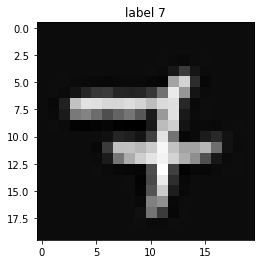

In [15]:
# tester une image
c= 69
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [61]:
y_pred = KPP(Xtt, Xt, Yt, 5, 1)

metrics(Ytt, y_pred)

Matrice de Confusion :
[[160   0   0   0   0   0   2   0   1   0]
 [  0 168   1   1   2   0   0   0   0   0]
 [  2   4 152   1   0   0   3   1   3   1]
 [  0   2   1 164   0   1   0   2   1   2]
 [  0   6   0   0 150   0   3   0   0  12]
 [  2   1   1   4   1 149   2   0   0   0]
 [  2   1   0   0   0   3 158   0   0   0]
 [  0   3   0   0   2   0   0 154   0   6]
 [  0   1   1   6   1   5   1   0 154   3]
 [  1   0   0   2   2   1   1   4   0 149]]

Rappel :
[0.9580838323353293, 0.9032258064516129, 0.9743589743589743, 0.9213483146067416, 0.9493670886075949, 0.9371069182389937, 0.9294117647058824, 0.9565217391304348, 0.9685534591194969, 0.861271676300578]
Rappel mean =  0.9359249573855639
-------------------------------------------------------
Precision :
[0.9815950920245399, 0.9767441860465116, 0.9101796407185628, 0.9479768786127167, 0.8771929824561403, 0.93125, 0.9634146341463414, 0.9333333333333333, 0.8953488372093024, 0.93125]

Precision mean =  0.9348285584547449
Taux de FP :
[0.0

# Méthode 1: MVS
Machine à Vecteurs de Support

In [122]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)
y_pred

array([0, 1, 9, ..., 3, 0, 1])

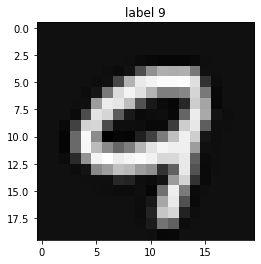

In [ ]:
# tester une image
c= 45
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [63]:
metrics(Ytt, y_pred)

Matrice de Confusion :
[[161   0   2   0   0   0   0   0   0   0]
 [  0 167   0   1   1   1   0   1   1   0]
 [  6   2 149   0   3   1   2   2   2   0]
 [  1   4   8 145   0   8   0   1   5   1]
 [  1   1   0   0 157   0   0   3   0   9]
 [  3   1   3   6   1 141   2   0   3   0]
 [  2   1   0   0   0   3 158   0   0   0]
 [  2   2   1   3   6   0   0 147   0   4]
 [  2   2   6   4   2   5   2   1 147   1]
 [  2   0   2   1   8   0   0   8   0 139]]

Rappel :
[0.8944444444444445, 0.9277777777777778, 0.8713450292397661, 0.90625, 0.8820224719101124, 0.8867924528301887, 0.9634146341463414, 0.901840490797546, 0.930379746835443, 0.9025974025974026]
Rappel mean =  0.9066864450579024
-------------------------------------------------------
Precision :
[0.9877300613496932, 0.9709302325581395, 0.8922155688622755, 0.838150289017341, 0.9181286549707602, 0.88125, 0.9634146341463414, 0.8909090909090909, 0.8546511627906976, 0.86875]

Precision mean =  0.906612969460434
Taux de FP :
[0.012269938650306

# Méthode 2: Arbres de décision


In [65]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

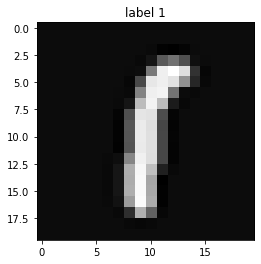

In [ ]:
# tester une image
c= 3
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [66]:
metrics(Ytt, y_pred)

Matrice de Confusion :
[[145   1   8   3   0   2   2   1   0   1]
 [  0 154   1   2   2   4   0   5   4   0]
 [  4   9 113   8   3   1   6  13   7   3]
 [  1   3   6 120   3  15   5   6   9   5]
 [  0   3   4   2 127   3   5   7   3  17]
 [  3   3   6  17   4 100   5   5   6  11]
 [  6   2   7   0   6  11 125   1   5   1]
 [  2   3   5   9   7   1   1 123   2  12]
 [  2   4  10   4   4   6   8   7 119   8]
 [  3   4   3   5   3   4   3   8   5 122]]

Rappel :
[0.8734939759036144, 0.8279569892473119, 0.6932515337423313, 0.7058823529411765, 0.7987421383647799, 0.6802721088435374, 0.78125, 0.6988636363636364, 0.74375, 0.6777777777777778]
Rappel mean =  0.7481240513184166
-------------------------------------------------------
Precision :
[0.8895705521472392, 0.8953488372093024, 0.6766467065868264, 0.6936416184971098, 0.7426900584795322, 0.625, 0.7621951219512195, 0.7454545454545455, 0.6918604651162791, 0.7625]

Precision mean =  0.7484907905442053
Taux de FP :
[0.11042944785276074, 0.1046

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [84]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

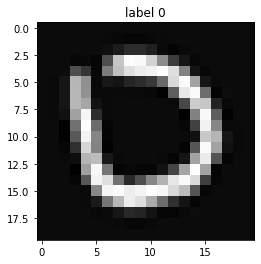

In [85]:
# Choisir un image de test 
c=0
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [89]:
y_pred = np.array(model.predict(Xtt), dtype=int)
y_pred

array([3, 4, 4, ..., 4, 4, 1])

In [92]:
metrics(Ytt, y_pred)

Matrice de Confusion :
[[ 37   0   0  37 235  45   0   0   0   0]
 [  1 332   4   0  14   0   0   0   0   0]
 [  4   8   6   0 335   1   0   0   0   0]
 [ 50   4   1  74 100 129   0   0   0   0]
 [  3   1   0   1 333   0   0   0   0   0]
 [ 14   1   0  27  50 258   1   0   0   0]
 [  4   0   0   1 335   2   1   0   0   0]
 [  3   4   1   0 342   0   0   0   0   0]
 [ 14   2   0   4 328   2   0   0   0   0]
 [  7   3   0   4 334   2   1   0   0   0]]

Rappel :
[0.27007299270072993, 0.9352112676056338, 0.5, 0.5, 0.13840399002493767, 0.5876993166287016, 0.3333333333333333, 0, 0, 0]
Rappel mean =  0.32647209002933364
-------------------------------------------------------
Precision :
[0.10451977401129943, 0.9458689458689459, 0.01694915254237288, 0.20670391061452514, 0.985207100591716, 0.7350427350427351, 0.0029154518950437317, 0.0, 0.0, 0.0]

Precision mean =  0.2997207070566638
Taux de FP :
[0.8954802259887006, 0.05413105413105413, 0.9830508474576272, 0.7932960893854749, 0.014792899408284

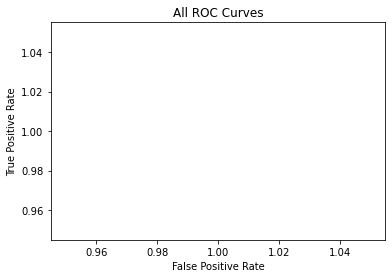

In [27]:
# pour ROC, il faudra les probabilités:
y_score = model.predict_proba(Xtt)
ROC(Ytt, y_pred, y_score)

Afficher l'image testée

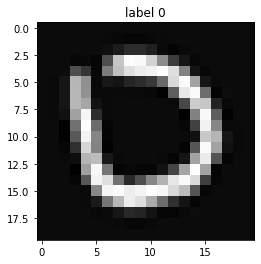

In [30]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [130]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [131]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)

y_proba = np.array(model.predict(Xtt_rncN))



In [138]:
y_pred = [np.array([], dtype=int)]
for yp in y_proba:
    y_pred = np.append(y_pred, np.where(yp == np.amax(yp)))
metrics(Ytt, y_pred)

Matrice de Confusion :
[[  0  14   3  48  44   0 232   0  13   0]
 [  0  14   0 278  54   0   0   0   5   0]
 [  0  37   5 165  38   0   9   0 100   0]
 [  0  18  50  72 175   0  34   1   8   0]
 [  0   6   1 254  60   0   8   0   9   0]
 [  0  23  26 188  53   0  51   2   7   1]
 [  0  36   0 230  13   0   1   0  63   0]
 [  0   8   0  64 199   0  76   0   3   0]
 [  0   9  11 236  61   0  25   4   4   0]
 [  0   3   2 229  85   0   8   1  23   0]]

Rappel :
[0, 0.08333333333333333, 0.05102040816326531, 0.04081632653061224, 0.07672634271099744, 0, 0.0022522522522522522, 0.0, 0.01702127659574468, 0.0]
Rappel mean =  0.02711699395862053
-------------------------------------------------------
Precision :
[0.0, 0.039886039886039885, 0.014124293785310734, 0.2011173184357542, 0.17751479289940827, 0.0, 0.0029154518950437317, 0.0, 0.011428571428571429, 0.0]

Precision mean =  0.04469864683301282
Taux de FP :
[1.0, 0.9601139601139601, 0.9858757062146892, 0.7988826815642458, 0.8224852071005917,

# Appliquer les métriques implementées pour voir le résultat

In [ ]:
#Les métriques ont été appliquer en dessous de chaque modèle pour plus de clareté 

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 4 Mars 2022 à 22h

La partie RNC peut être laissée pour le prochain TP

In [ ]:
# bonne chance